In [1]:
import pandas as pd
import numpy as np
import pickle
import glob
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor

In [2]:
# List all CSV files in the directory
csv_files = glob.glob("*.csv")

In [3]:
csv_files

['ResaleFlatPricesBasedonApprovalDate2000Feb2012.csv',
 'ResaleFlatPricesBasedonRegistrationDateFromJan2015toDec2016.csv',
 'ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv',
 'ResaleFlatPricesBasedonRegistrationDateFromMar2012toDec2014.csv',
 'ResaleFlatPricesBasedonApprovalDate19901999.csv']

In [4]:
# Initialize an empty list to hold DataFrames
df_list = []

# Iterate over the list of files and read each into a DataFrame
for file in csv_files:
    df = pd.read_csv(file)
    df_list.append(df)

In [5]:
# Concatenate all DataFrames into a single DataFrame
data = pd.concat(df_list, ignore_index=True)

In [6]:
data

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,2000-01,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0,Improved,1986,147000.0,NaN
1,2000-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0,Improved,1986,144000.0,NaN
2,2000-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,159000.0,NaN
3,2000-01,ANG MO KIO,3 ROOM,215,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,167000.0,NaN
4,2000-01,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,07 TO 09,67.0,New Generation,1976,163000.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
932886,1999-12,YISHUN,EXECUTIVE,611,YISHUN ST 61,10 TO 12,142.0,APARTMENT,1987,456000.0,NaN
932887,1999-12,YISHUN,EXECUTIVE,324,YISHUN CTRL,01 TO 03,142.0,APARTMENT,1988,408000.0,NaN
932888,1999-12,YISHUN,EXECUTIVE,392,YISHUN AVE 6,07 TO 09,146.0,MAISONETTE,1988,469000.0,NaN
932889,1999-12,YISHUN,EXECUTIVE,356,YISHUN RING RD,04 TO 06,146.0,MAISONETTE,1988,440000.0,NaN


In [7]:
data.shape

(932891, 11)

In [8]:
data.drop_duplicates(inplace=True)

In [9]:
data.shape

(930992, 11)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 930992 entries, 0 to 932890
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                930992 non-null  object 
 1   town                 930992 non-null  object 
 2   flat_type            930992 non-null  object 
 3   block                930992 non-null  object 
 4   street_name          930992 non-null  object 
 5   storey_range         930992 non-null  object 
 6   floor_area_sqm       930992 non-null  float64
 7   flat_model           930992 non-null  object 
 8   lease_commence_date  930992 non-null  int64  
 9   resale_price         930992 non-null  float64
 10  remaining_lease      223529 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 85.2+ MB


In [11]:
data.isnull().sum()

month                       0
town                        0
flat_type                   0
block                       0
street_name                 0
storey_range                0
floor_area_sqm              0
flat_model                  0
lease_commence_date         0
resale_price                0
remaining_lease        707463
dtype: int64

In [12]:
data.isnull().sum()/len(data)*100

month                   0.000000
town                    0.000000
flat_type               0.000000
block                   0.000000
street_name             0.000000
storey_range            0.000000
floor_area_sqm          0.000000
flat_model              0.000000
lease_commence_date     0.000000
resale_price            0.000000
remaining_lease        75.990234
dtype: float64

### Dropping remaining_lease column as null % is high

In [13]:
data.drop('remaining_lease', axis=1, inplace=True)

### Change datatypes and split month & year

In [14]:
data['month'] = pd.to_datetime(data['month'])
data['year'] = data['month'].dt.year
data['month'] = data['month'].dt.month

In [15]:
data

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,year
0,1,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0,Improved,1986,147000.0,2000
1,1,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0,Improved,1986,144000.0,2000
2,1,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,159000.0,2000
3,1,ANG MO KIO,3 ROOM,215,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,167000.0,2000
4,1,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,07 TO 09,67.0,New Generation,1976,163000.0,2000
...,...,...,...,...,...,...,...,...,...,...,...
932886,12,YISHUN,EXECUTIVE,611,YISHUN ST 61,10 TO 12,142.0,APARTMENT,1987,456000.0,1999
932887,12,YISHUN,EXECUTIVE,324,YISHUN CTRL,01 TO 03,142.0,APARTMENT,1988,408000.0,1999
932888,12,YISHUN,EXECUTIVE,392,YISHUN AVE 6,07 TO 09,146.0,MAISONETTE,1988,469000.0,1999
932889,12,YISHUN,EXECUTIVE,356,YISHUN RING RD,04 TO 06,146.0,MAISONETTE,1988,440000.0,1999


In [16]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
month,930992.0,6.552377,3.403613,1.0,4.0,7.0,9.0,12.0
floor_area_sqm,930992.0,95.710618,25.813679,28.0,73.0,93.0,113.0,366.7
lease_commence_date,930992.0,1988.341398,10.722622,1966.0,1981.0,1986.0,1996.0,2020.0
resale_price,930992.0,322700.146702,172141.123518,5000.0,195000.0,299000.0,420000.0,1588000.0
year,930992.0,2006.282764,9.395478,1990.0,1999.0,2005.0,2014.0,2024.0


In [17]:
# Calculate correlation matrix
numeric_data = data.select_dtypes(include=[float, int])
corr_matrix = numeric_data.corr()

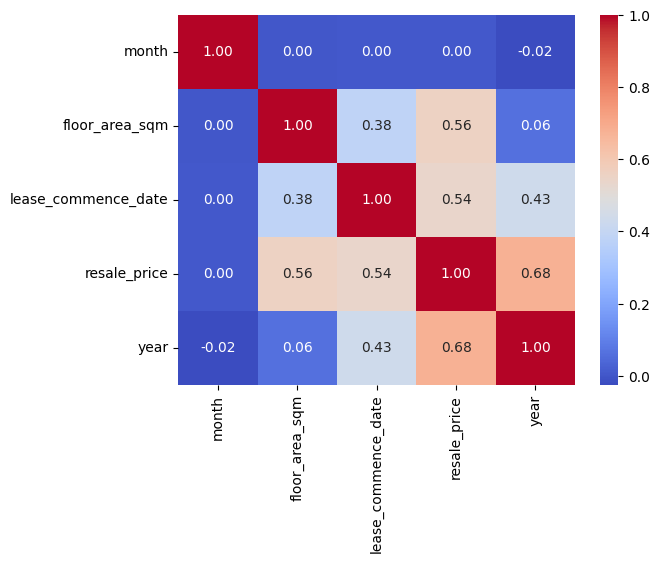

In [18]:
# Create heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [19]:
features = ['floor_area_sqm','lease_commence_date','resale_price', 'year']

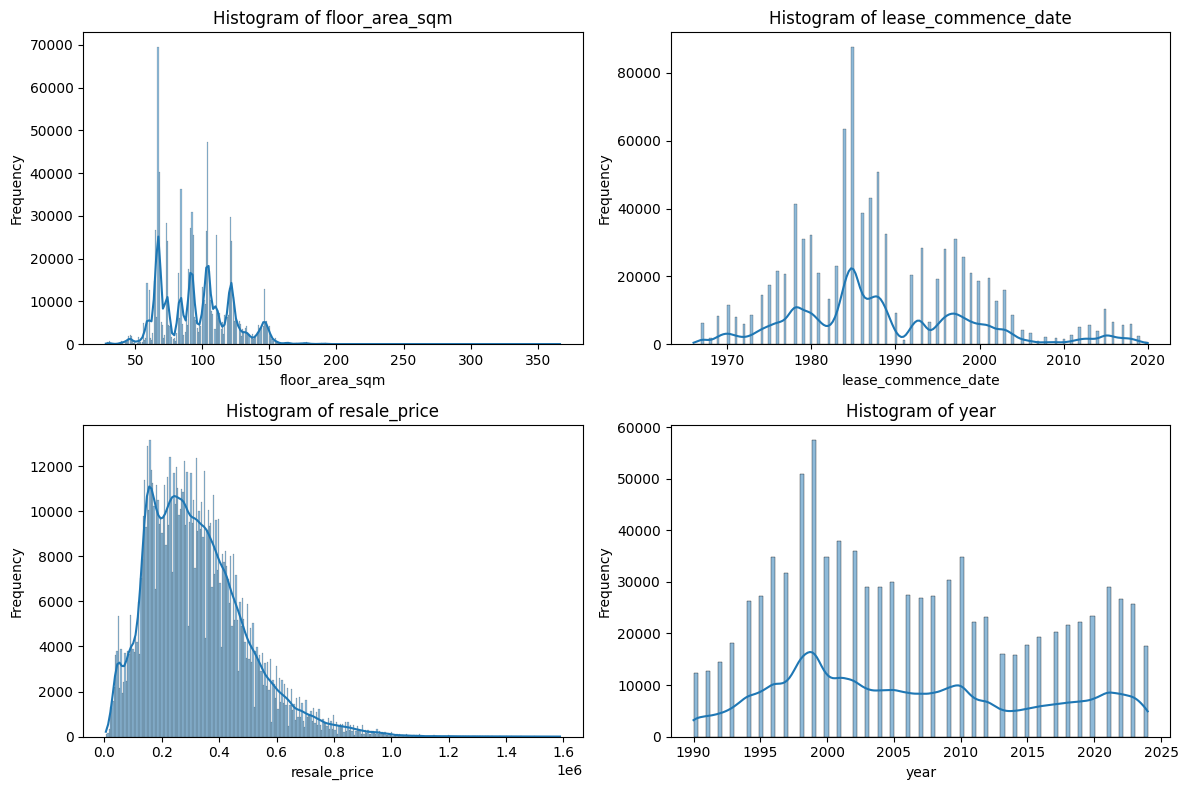

In [20]:
# Plot histograms for each feature
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.histplot(data[feature], kde=True)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

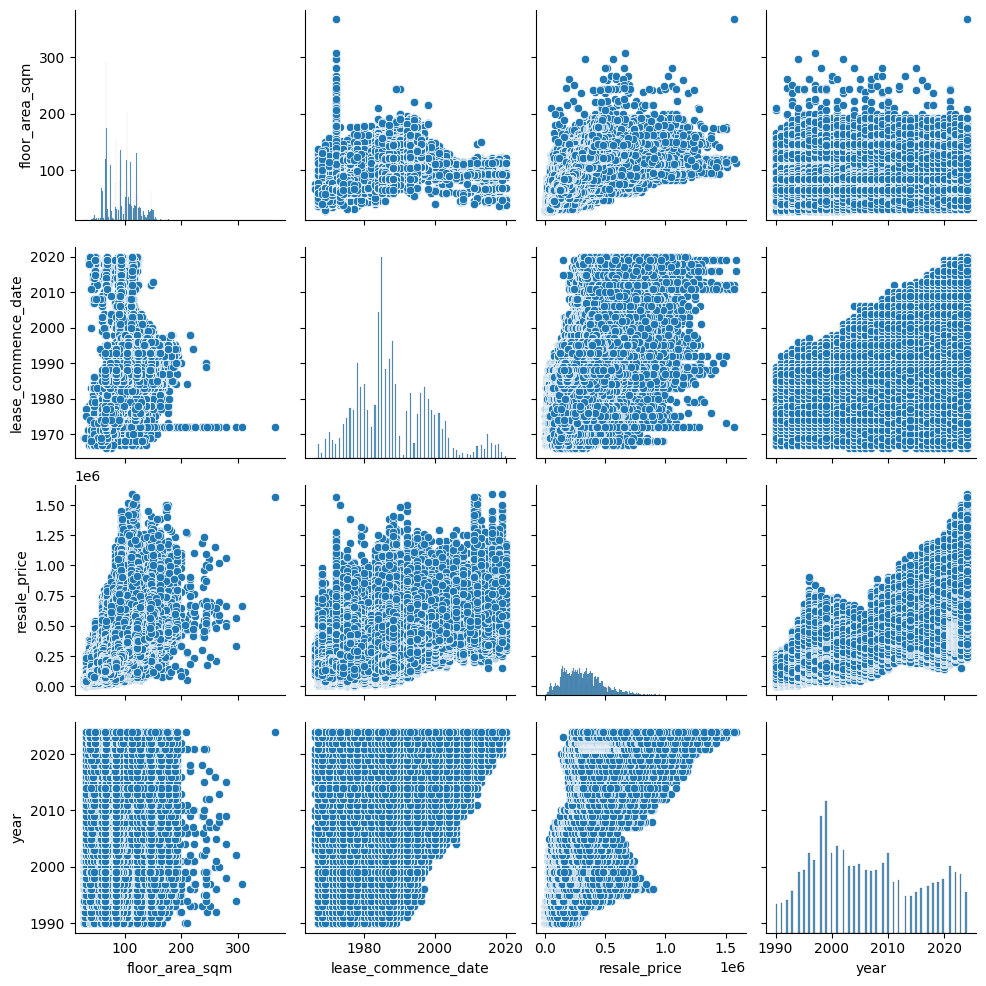

In [21]:
sns.pairplot(data[features])
plt.show() 

In [22]:
X = data[features]

# Calculate Q1 and Q3
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)

# Compute IQR
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = ((X < lower_bound) | (X > upper_bound)).any(axis=1)
outliers_df = data[outliers]

print(f'Number of outliers detected: {outliers_df.shape[0]}')

Number of outliers detected: 24538


In [23]:
# Check skewness 
skewness = data[features].skew()
print(skewness)

floor_area_sqm         0.366527
lease_commence_date    0.653745
resale_price           0.956188
year                   0.292580
dtype: float64


In [24]:
# Cap outliers at the boundary values
data_capped = data.copy()
for column in X.columns:
    data_capped[column] = np.where(data_capped[column] > upper_bound[column], upper_bound[column],
                                   np.where(data_capped[column] < lower_bound[column], lower_bound[column],
                                            data_capped[column]))

In [25]:
# Log transformation on resale_price
data_capped['resale_price'] = np.log1p(data_capped['resale_price'])

In [26]:
# Check skewness for capped data
skewness = data_capped[features].skew()
print(skewness)

floor_area_sqm         0.330717
lease_commence_date    0.650076
resale_price          -0.973991
year                   0.292580
dtype: float64


In [27]:
new_data = data_capped.copy()

In [28]:
new_data.drop(['month', 'block', 'street_name'], axis=1, inplace=True)

In [29]:
new_data.shape

(930992, 8)

In [30]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 930992 entries, 0 to 932890
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   town                 930992 non-null  object 
 1   flat_type            930992 non-null  object 
 2   storey_range         930992 non-null  object 
 3   floor_area_sqm       930992 non-null  float64
 4   flat_model           930992 non-null  object 
 5   lease_commence_date  930992 non-null  float64
 6   resale_price         930992 non-null  float64
 7   year                 930992 non-null  float64
dtypes: float64(4), object(4)
memory usage: 63.9+ MB


In [31]:
new_data

,town,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,year
0,ANG MO KIO,3 ROOM,07 TO 09,69.0,Improved,1986.0,11.898195,2000.0
1,ANG MO KIO,3 ROOM,04 TO 06,61.0,Improved,1986.0,11.877576,2000.0
2,ANG MO KIO,3 ROOM,07 TO 09,73.0,New Generation,1976.0,11.976666,2000.0
3,ANG MO KIO,3 ROOM,07 TO 09,73.0,New Generation,1976.0,12.025755,2000.0
4,ANG MO KIO,3 ROOM,07 TO 09,67.0,New Generation,1976.0,12.001512,2000.0
...,...,...,...,...,...,...,...,...
932886,YISHUN,EXECUTIVE,10 TO 12,142.0,APARTMENT,1987.0,13.030250,1999.0
932887,YISHUN,EXECUTIVE,01 TO 03,142.0,APARTMENT,1988.0,12.919025,1999.0
932888,YISHUN,EXECUTIVE,07 TO 09,146.0,MAISONETTE,1988.0,13.058360,1999.0
932889,YISHUN,EXECUTIVE,04 TO 06,146.0,MAISONETTE,1988.0,12.994532,1999.0


In [32]:
new_data.to_csv('Data.csv', index=False)

### Model Selection and Evaluation

In [33]:
X = new_data.drop('resale_price', axis=1)
y = new_data['resale_price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
categorical_features = X_train.select_dtypes(include='object').columns.tolist()
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Initialize the OneHotEncoder and StandardScaler
onehotencoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# Use ColumnTransformer to apply StandardScaler to numerical features and OneHotEncoder to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Apply StandardScaler to numeric features
        ('cat', onehotencoder, categorical_features)  # Apply OneHotEncoder to categorical features
    ])

In [35]:
def model_pipeline(model):
    # Create a pipeline with preprocessor and the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),  # Preprocessor for scaling and encoding
        ('model', model())  # Model passed as an argument
    ])
    
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Print the evaluation metrics
    print(f"{model.__name__} - Mean Absolute Error: {mae:.2f}, Mean Squared Error: {mse:.2f}, Root Mean Squared Error: {rmse:.2f}, R-squared (R2): {r2:.2f}")

    return pipeline

In [36]:
pipeline1 = model_pipeline(LinearRegression)
pipeline2 = model_pipeline(DecisionTreeRegressor)
pipeline3 = model_pipeline(AdaBoostRegressor)
pipeline4 = model_pipeline(GradientBoostingRegressor)
pipeline5 = model_pipeline(XGBRegressor)
pipeline6 = model_pipeline(RandomForestRegressor)

LinearRegression - Mean Absolute Error: 0.19, Mean Squared Error: 0.07, Root Mean Squared Error: 0.26, R-squared (R2): 0.81
DecisionTreeRegressor - Mean Absolute Error: 0.07, Mean Squared Error: 0.01, Root Mean Squared Error: 0.11, R-squared (R2): 0.97
AdaBoostRegressor - Mean Absolute Error: 0.19, Mean Squared Error: 0.06, Root Mean Squared Error: 0.24, R-squared (R2): 0.85
GradientBoostingRegressor - Mean Absolute Error: 0.11, Mean Squared Error: 0.02, Root Mean Squared Error: 0.14, R-squared (R2): 0.95
XGBRegressor - Mean Absolute Error: 0.07, Mean Squared Error: 0.01, Root Mean Squared Error: 0.10, R-squared (R2): 0.97
RandomForestRegressor - Mean Absolute Error: 0.07, Mean Squared Error: 0.01, Root Mean Squared Error: 0.10, R-squared (R2): 0.97


In [39]:
def cross_validation(model):
    # Create the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),  # Preprocessor step
        ('model', model())  # Model passed as an argument
    ])
    
    # Perform cross-validation and calculate negative MSE
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
    
    # Convert negative MSE to positive
    mse_scores = -cv_scores

    # Calculate RMSE from MSE scores
    rmse = np.sqrt(mse_scores.mean())
    std_score = cv_scores.std()
    
    print(f"{model.__name__} Cross-Validation Results:")
    print(f"Cross-Validation MSE: {mse_scores.mean():.2f} (± {mse_scores.std():.2f})")
    print(f"Cross-Validation RMSE: {rmse:.2f}")
    print(f"Cross-Validation Std: {std_score:.2f}")
    
    return mse_scores, std_score


In [40]:
# Loop through models and perform cross-validation
for model in [LinearRegression, DecisionTreeRegressor, AdaBoostRegressor, GradientBoostingRegressor, XGBRegressor, RandomForestRegressor]:
    cross_validation(model)

/Applications/anaconda3/envs/my-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/envs/my-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


LinearRegression Cross-Validation Results:
Cross-Validation MSE: 0.18 (± 0.15)
Cross-Validation RMSE: 0.42
Cross-Validation Std: 0.15


/Applications/anaconda3/envs/my-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/envs/my-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


DecisionTreeRegressor Cross-Validation Results:
Cross-Validation MSE: 0.10 (± 0.11)
Cross-Validation RMSE: 0.31
Cross-Validation Std: 0.11


/Applications/anaconda3/envs/my-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/envs/my-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


AdaBoostRegressor Cross-Validation Results:
Cross-Validation MSE: 0.14 (± 0.13)
Cross-Validation RMSE: 0.37
Cross-Validation Std: 0.13


/Applications/anaconda3/envs/my-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/envs/my-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


GradientBoostingRegressor Cross-Validation Results:
Cross-Validation MSE: 0.11 (± 0.14)
Cross-Validation RMSE: 0.33
Cross-Validation Std: 0.14


/Applications/anaconda3/envs/my-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/envs/my-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


XGBRegressor Cross-Validation Results:
Cross-Validation MSE: 0.11 (± 0.11)
Cross-Validation RMSE: 0.33
Cross-Validation Std: 0.11


/Applications/anaconda3/envs/my-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/envs/my-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


RandomForestRegressor Cross-Validation Results:
Cross-Validation MSE: 0.09 (± 0.11)
Cross-Validation RMSE: 0.31
Cross-Validation Std: 0.11


In [ ]:
LinearRegression: Cross-Validation RMSE: 0.42, Root Mean Squared Error: 0.26
DecisionTreeRegressor: Cross-Validation RMSE: 0.31, Root Mean Squared Error: 0.11
AdaBoostRegressor: Cross-Validation RMSE: 0.37,Root Mean Squared Error: 0.24
GradientBoostingRegressor: Cross-Validation RMSE: 0.33, Root Mean Squared Error: 0.14
XGBRegressor: Cross-Validation RMSE: 0.33, Root Mean Squared Error: 0.10
RandomForestRegressor: Cross-Validation RMSE: 0.31, Root Mean Squared Error: 0.10

In [41]:
# Save the Random Forest model
with open('RandomForest.pkl', 'wb') as file:
    pickle.dump(pipeline6, file)

In [42]:
# Load the model
with open('RandomForest.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [43]:
# Create new data for prediction
new_data = pd.DataFrame({
    'town': ['ANG MO KIO'],
    'flat_type': ['3 ROOM'],
    'storey_range': ['07 TO 09'],
    'floor_area_sqm': [108],
    'flat_model': ['Apartment'],
    'lease_commence_date': [2019],
    'year': [2019]
})

# Ensure new_data is preprocessed the same way as during training
predicted_price = pipeline6.predict(new_data)


In [44]:
predicted_price

array([13.3065003])

In [45]:
# Revert log transformation to get the actual predicted price
predicted_price_actual = np.exp(predicted_price)

In [46]:
predicted_price_actual

array([601090.20705269])